# 24.3 Flexible TWFE: Fixing the Bias

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Implementation](#implementation)
4. [Numeric Demonstration](#numeric)
5. [Interview Appendix](#interview)
6. [References](#references)

---

## Learning Objectives

By the end of this notebook, you will:
- Implement the Sun-Abraham/Wooldridge flexible TWFE fix
- Use cohort × date interactions to allow heterogeneous effects
- Validate counterfactuals visually
- Reduce model complexity through clever feature engineering

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from toolz import curry
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(1)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Intuition <a name="intuition"></a>

### The Problem Recap

Standard TWFE assumes constant treatment effect:
$$Y_{it} = \tau D_{it} + \gamma_i + \theta_t + \epsilon_{it}$$

This forces $\tau_{gt} = \tau$ for all cohorts $g$ and times $t$.

### The Solution: Let Effects Vary

Allow different effects by cohort and time:
$$Y_{it} = \sum_g \sum_t \tau_{gt} D_{it} + \gamma_i + \theta_t + \epsilon_{it}$$

This is implemented via **cohort × date interactions** in the regression formula.

### Why This Works

1. **No forbidden comparisons**: Each cohort has its own effect trajectory
2. **Flexible functional form**: Can capture ramping, decay, or any pattern
3. **Easy to implement**: Just add interactions to the formula

### Trade-off

- More parameters ($G \times T$ treatment effect parameters)
- Requires enough data per cohort-date cell

---

## 2. Formal Treatment <a name="formal"></a>

### Fully Saturated Model

$$Y_{it} = \sum_{g=1}^G \sum_{t=1}^T \tau_{gt} \cdot \mathbf{1}\{\text{cohort}_i = g\} \cdot \mathbf{1}\{\text{date} = t\} \cdot D_{it} + \gamma_i + \theta_t + \epsilon_{it}$$

### Practical Formula

```python
installs ~ treat:C(cohort):C(date) + C(unit) + C(date)
```

### Parameter Reduction

Under **no anticipation**, effects are zero before treatment. We can drop those parameters:

1. **Drop pre-treatment interactions** for each cohort
2. **Drop never-treated cohort** (effect always zero)

This reduces from $G \times T$ to approximately $\sum_{g=1}^{G-1} (T - t_g)$ parameters.

### Counterfactual Estimation

Predict $\hat{Y}_0$ by setting `treat = 0`:
- All interaction terms zero out
- Only unit and time fixed effects remain
- Counterfactual = "what would have happened without treatment"

---

## 3. Implementation <a name="implementation"></a>

### Recreate the Biased Data

In [2]:
# Generate panel with time-varying effects (10-day ramp)
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"])
units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    # 10-day ramp to full effect
    y1 = lambda d: d["y0"] + np.minimum(
        0.1 * np.maximum(0, (d["date"] - d["cohort"]).dt.days),
        1.0
    )
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

# Convert to string for formula compatibility
df_heter_str = df_heter.astype({"cohort": str, "date": str})

true_att = df_heter.query("treat==1")["tau"].mean()
print(f"True ATT: {true_att:.4f}")

True ATT: 0.8544


In [3]:
# Standard TWFE (biased)
twfe_biased = smf.ols("installs ~ treat + C(unit) + C(date)", data=df_heter).fit()
print(f"Standard TWFE (biased): {twfe_biased.params['treat']:.4f}")
print(f"Bias: {twfe_biased.params['treat'] - true_att:.4f}")

Standard TWFE (biased): 0.7868
Bias: -0.0676


### Flexible TWFE with Cohort × Date Interactions

In [4]:
# Fully flexible TWFE
formula_flex = "installs ~ treat:C(cohort):C(date) + C(unit) + C(date)"

twfe_flex = smf.ols(formula_flex, data=df_heter_str).fit()

print(f"Flexible TWFE parameters: {len(twfe_flex.params)}")

Flexible TWFE parameters: 467


In [5]:
# Predict counterfactual and estimate effect
df_pred = df_heter_str.assign(
    installs_hat_0 = twfe_flex.predict(df_heter_str.assign(treat=0)),
    effect_hat = lambda d: d["installs"].astype(float) - d["installs_hat_0"]
)

estimated_att = df_pred.query("treat==1")["effect_hat"].mean()

print("Flexible TWFE Results:")
print(f"  True ATT:      {true_att:.4f}")
print(f"  Estimated ATT: {estimated_att:.4f}")
print(f"  Bias:          {estimated_att - true_att:.6f}")
print(f"\n✓ Flexible TWFE recovers the true effect!")

Flexible TWFE Results:
  True ATT:      0.8544
  Estimated ATT: 0.8544
  Bias:          -0.000000

✓ Flexible TWFE recovers the true effect!


---

## 4. Numeric Demonstration <a name="numeric"></a>

### Extract and Plot Cohort-Specific Effects

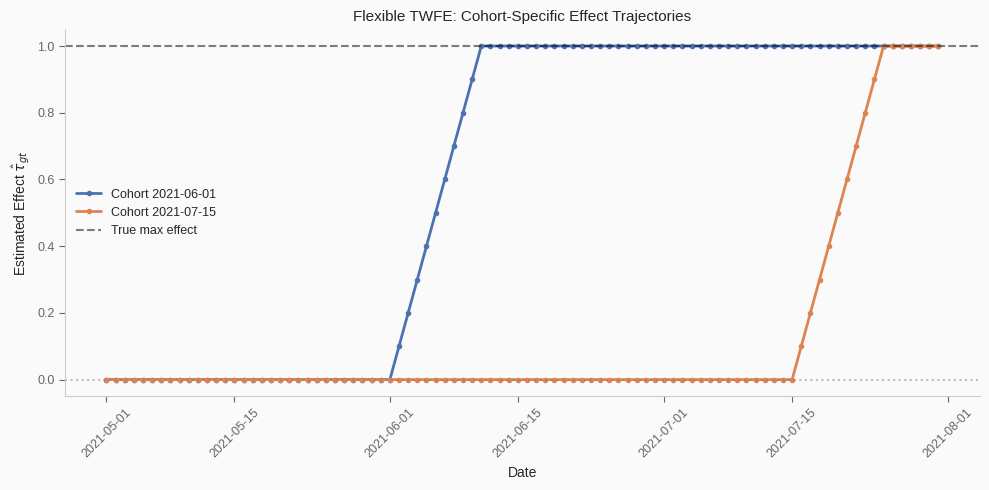

In [6]:
# Extract treatment effect parameters
effects = (
    twfe_flex.params[twfe_flex.params.index.str.contains("treat")]
    .reset_index()
    .rename(columns={0: "param"})
    .assign(
        cohort = lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'),
        date = lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]')
    )
    .assign(
        date = lambda d: pd.to_datetime(d["date"]),
        cohort = lambda d: pd.to_datetime(d["cohort"])
    )
)

# Plot
fig, ax = create_tufte_figure(figsize=(10, 5))

for cohort_val, color in [(pd.Timestamp('2021-06-01'), COLORS['blue']), 
                           (pd.Timestamp('2021-07-15'), COLORS['orange'])]:
    cohort_effects = effects[effects['cohort'] == cohort_val]
    ax.plot(cohort_effects['date'], cohort_effects['param'], 
            color=color, linewidth=2, marker='o', markersize=3,
            label=f'Cohort {cohort_val.date()}')

ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='True max effect')
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Estimated Effect $\\hat{\\tau}_{gt}$')
ax.set_title('Flexible TWFE: Cohort-Specific Effect Trajectories')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**: The estimated effects show the expected pattern:
- Zero before treatment
- Ramp up over 10 days
- Plateau at ~1.0

### Counterfactual Validation

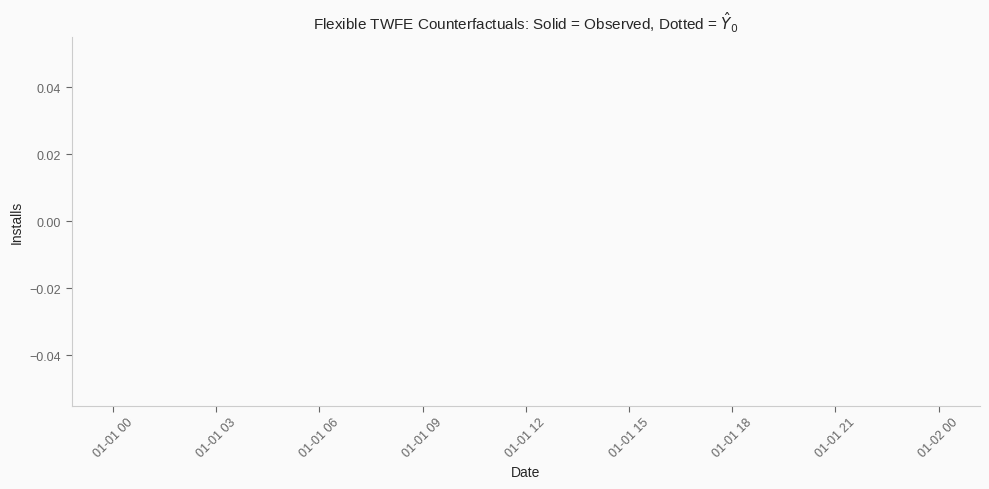

✓ Counterfactuals align with control cohort trend (as expected)


In [7]:
# Plot counterfactuals vs actuals
fig, ax = create_tufte_figure(figsize=(10, 5))

# Group by cohort and date
plot_data = (
    df_pred
    .groupby(["cohort", "date"])[["installs", "installs_hat_0"]]
    .mean()
    .reset_index()
)
plot_data['date'] = pd.to_datetime(plot_data['date'])

colors_cohort = {str(cohorts[0]): COLORS['blue'], 
                 str(cohorts[1]): COLORS['orange'], 
                 str(cohorts[2]): COLORS['gray']}

# Plot actual outcomes
for cohort_str in [str(cohorts[0]), str(cohorts[1]), str(cohorts[2])]:
    data = plot_data[plot_data['cohort'] == cohort_str]
    ax.plot(data['date'], data['installs'], 
            color=colors_cohort[cohort_str], linewidth=2)

# Plot counterfactuals for treated cohorts
for cohort_str, cohort_date in [(str(cohorts[0]), pd.Timestamp('2021-06-01')),
                                 (str(cohorts[1]), pd.Timestamp('2021-07-15'))]:
    data = plot_data[(plot_data['cohort'] == cohort_str) & 
                     (plot_data['date'] >= cohort_date)]
    ax.plot(data['date'], data['installs_hat_0'], 
            color=colors_cohort[cohort_str], linewidth=1.5, linestyle=':')

ax.set_xlabel('Date')
ax.set_ylabel('Installs')
ax.set_title('Flexible TWFE Counterfactuals: Solid = Observed, Dotted = $\\hat{Y}_0$')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Counterfactuals align with control cohort trend (as expected)")

### Parameter Reduction via Feature Engineering

In [8]:
def feature_eng(df):
    """
    Feature engineering to reduce parameters:
    - Collapse pre-treatment dates to 'control' category
    - Create explicit cohort dummies
    """
    return df.assign(
        # Date columns that collapse pre-treatment to 'control'
        date_0601 = np.where(df["date"] >= "2021-06-01", df["date"], "control"),
        date_0715 = np.where(df["date"] >= "2021-07-15", df["date"], "control"),
        # Cohort dummies
        cohort_0601 = (df["cohort"] == "2021-06-01").astype(float),
        cohort_0715 = (df["cohort"] == "2021-07-15").astype(float)
    )

# Reduced formula: only post-treatment interactions
formula_reduced = """
    installs ~ treat:cohort_0601:C(date_0601) 
             + treat:cohort_0715:C(date_0715) 
             + C(unit) + C(date)
"""

twfe_reduced = smf.ols(formula_reduced, data=df_heter_str.pipe(feature_eng)).fit()

print(f"Full model parameters:    {len(twfe_flex.params)}")
print(f"Reduced model parameters: {len(twfe_reduced.params)}")
print(f"Parameter reduction:      {len(twfe_flex.params) - len(twfe_reduced.params)}")

Full model parameters:    467
Reduced model parameters: 271
Parameter reduction:      196


In [9]:
# Verify reduced model gives same result
df_pred_reduced = df_heter.assign(
    installs_hat_0 = twfe_reduced.predict(df_heter_str.pipe(feature_eng).assign(treat=0)),
    effect_hat = lambda d: d["installs"] - d["installs_hat_0"]
)

estimated_att_reduced = df_pred_reduced.query("treat==1")["effect_hat"].mean()

print("Reduced Model Results:")
print(f"  True ATT:      {true_att:.4f}")
print(f"  Estimated ATT: {estimated_att_reduced:.4f}")
print(f"  Difference from full model: {abs(estimated_att - estimated_att_reduced):.6f}")

Reduced Model Results:
  True ATT:      0.8544
  Estimated ATT: 0.8544
  Difference from full model: 0.000000


### Comparison: Standard vs Flexible TWFE

In [10]:
# Summary comparison
results = pd.DataFrame({
    'Method': ['True ATT', 'Standard TWFE', 'Flexible TWFE'],
    'Estimate': [true_att, twfe_biased.params['treat'], estimated_att],
    'Bias': [0, twfe_biased.params['treat'] - true_att, estimated_att - true_att]
})

print(results.to_string(index=False))

       Method  Estimate    Bias
     True ATT    0.8544  0.0000
Standard TWFE    0.7868 -0.0676
Flexible TWFE    0.8544 -0.0000


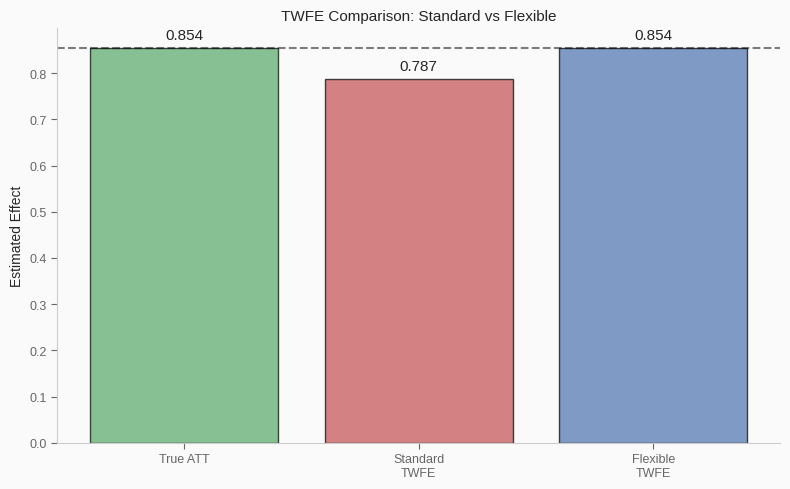

In [11]:
# Visual comparison
fig, ax = create_tufte_figure(figsize=(8, 5))

methods = ['True ATT', 'Standard\nTWFE', 'Flexible\nTWFE']
values = [true_att, twfe_biased.params['treat'], estimated_att]
colors = [COLORS['green'], COLORS['red'], COLORS['blue']]

bars = ax.bar(methods, values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', fontsize=11)

ax.axhline(y=true_att, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('Estimated Effect')
ax.set_title('TWFE Comparison: Standard vs Flexible')

plt.tight_layout()
plt.show()

---

## 5. Interview Appendix <a name="interview"></a>

### Q1: How do you fix TWFE bias from time-varying treatment effects?

<details>
<summary>Solution</summary>

**Solution**: Allow treatment effects to vary by cohort and time.

**Implementation**:
```python
# Standard TWFE (biased)
Y ~ treat + C(unit) + C(date)

# Flexible TWFE (unbiased)
Y ~ treat:C(cohort):C(date) + C(unit) + C(date)
```

**Why it works**:
1. Each cohort gets its own effect trajectory
2. No cohort serves as "control" for another cohort's post-treatment period
3. Avoids the forbidden comparisons that cause bias

**Trade-off**: More parameters, requires sufficient data per cohort-date cell.

</details>

### Q2: What is the Sun-Abraham approach to staggered DiD?

<details>
<summary>Solution</summary>

**Sun & Abraham (2021)** propose estimating cohort-time specific effects and then aggregating.

**Key steps**:
1. Estimate $\hat{\tau}_{gt}$ for each cohort $g$ and time $t \geq g$
2. Choose a weighting scheme (e.g., uniform, sample-size weighted)
3. Aggregate: $\hat{\tau} = \sum_{g,t} w_{gt} \hat{\tau}_{gt}$

**Connection to our implementation**:
- The `treat:C(cohort):C(date)` formula estimates all $\tau_{gt}$
- We aggregate by taking the mean over treated observations

**Alternative**: Callaway-Sant'Anna uses a different aggregation approach with explicit weighting.

</details>

### Q3: How do you reduce the number of parameters in flexible TWFE?

<details>
<summary>Solution</summary>

**Under no anticipation assumption**:
- Treatment effects are zero before treatment
- Don't need parameters for pre-treatment cohort-date pairs

**Implementation**:
1. Create date columns that collapse pre-treatment dates to a single category
2. Create explicit cohort dummies (excluding never-treated)
3. Interact only post-treatment dates with cohort dummies

```python
# Feature engineering
df['date_c1'] = np.where(df['date'] >= cohort1_date, df['date'], 'control')
df['cohort_c1'] = (df['cohort'] == cohort1_date).astype(float)

# Reduced formula
Y ~ treat:cohort_c1:C(date_c1) + ... + C(unit) + C(date)
```

**Reduction**: From $G \times T$ to approximately $(T - \bar{t}_g) \times (G-1)$ treatment parameters.

</details>

---

## 6. References <a name="references"></a>

1. **Sun, L. & Abraham, S.** (2021). *Estimating Dynamic Treatment Effects in Event Studies with Heterogeneous Treatment Effects*. Journal of Econometrics.

2. **Wooldridge, J.M.** (2021). *Two-Way Fixed Effects, the Two-Way Mundlak Regression, and Difference-in-Differences Estimators*. Working Paper.

3. **Callaway, B. & Sant'Anna, P.H.C.** (2021). *Difference-in-Differences with Multiple Time Periods*. Journal of Econometrics.

4. **Facure, M.** (2022). *Causal Inference for the Brave and True*, Chapter 24.